In [8]:
import torch
from torch import nn
import torchvision
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [12]:
if torch.cuda.is_available():
    batch_size=256
    if torch.cuda.device_count() > 1:
        device='cuda:1'
    else:
        device='cuda:0'
else:
    batch_size=64
    device='cpu'

## MNIST

In [14]:
dl_train = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('../data/mnist', train=True, download=True))

dl_test  = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('../data/mnist', train=False, download=True))

In [15]:
train_data   = dl_train.dataset.data.to(dtype=torch.float32)
train_labels = dl_train.dataset.targets

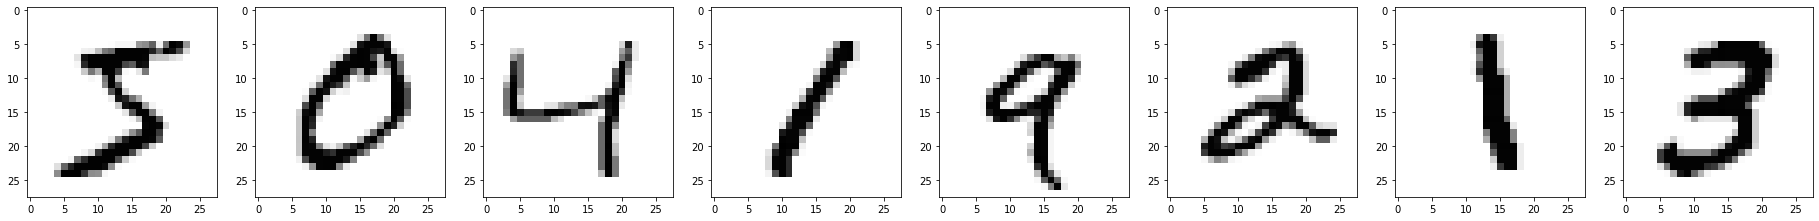

In [16]:
fig_mnist, ax = plt.subplots(1,8, figsize=(8*4,4))
for i in range(8):
    ax[i].imshow(train_data[i].numpy(), cmap='Greys');

In [17]:
train_labels[0:8]

tensor([5, 0, 4, 1, 9, 2, 1, 3])

## Standarisation/Normalisation

In [18]:
train_dataset = torch.utils.data.TensorDataset( 
    (train_data/128.0-1.0).view(-1,28*28).to(device=device), 
    train_labels.to(device=device))

In [19]:
train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=128, 
                                           shuffle=True)

In [20]:
test_data   = dl_test.dataset.data.to(dtype=torch.float32)
test_labels = dl_test.dataset.targets
test_dataset = torch.utils.data.TensorDataset(
    (test_data/128.8-1.0).view(-1,28*28).to(device=device), test_labels.to(device=device))

In [21]:
model = torch.nn.Sequential(
    nn.Linear(28*28,1200), nn.ReLU(),
    nn.Linear(1200,1200), nn.ReLU(),
    nn.Linear(1200,1200), nn.ReLU(),
    nn.Linear(1200,10),
)
model.to(device=device)

Sequential(
  (0): Linear(in_features=784, out_features=1200, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1200, out_features=1200, bias=True)
  (3): ReLU()
  (4): Linear(in_features=1200, out_features=1200, bias=True)
  (5): ReLU()
  (6): Linear(in_features=1200, out_features=10, bias=True)
)

In [22]:
optim = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.6)

In [23]:
loss_f = nn.CrossEntropyLoss()

In [24]:
errors = []
batches = 0
epochs = 0

In [25]:
%%time
model.train()
for e in range(5):
    for d in train_loader:        
        optim.zero_grad()
        features, labels = d
        pred = model(features)
        loss = loss_f(pred, labels)
        errors.append(loss.item())
        loss.backward()
        optim.step()
        batches += 1
    epochs += 1   
print(loss)        

tensor(0.0498, grad_fn=<NllLossBackward>)
CPU times: user 11min 41s, sys: 22.2 s, total: 12min 4s
Wall time: 1min 8s


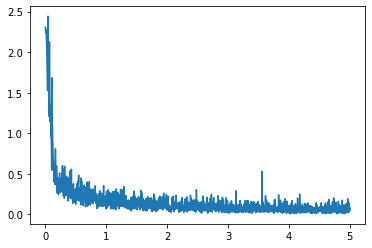

In [26]:
plt.plot(np.linspace(0,epochs, batches),errors)

In [35]:
model.eval()
with torch.no_grad():
    pred = torch.softmax(model(train_dataset[:][0]),1)
    ac = torch.sum(torch.argmax(pred,1)==train_dataset[:][1]).to(dtype=torch.float32)/len(train_dataset)
ac  

tensor(0.9838)

In [36]:
model.eval()
with torch.no_grad():
    pred = torch.softmax(model(test_dataset[:][0]),1)
    ac = torch.sum(torch.argmax(pred,1)==test_dataset[:][1]).to(dtype=torch.float32)/len(test_dataset)
ac    

tensor(0.9735)

## Batch normalisation

$$\hat{x}_{ij} = \frac{x_{ij}-\mu_j}{\sigma_j},
\quad \mu_j=\frac{1}{N_{batch}}\sum_{i\in batch} x_{ij},
\quad \sigma_j = \sqrt{\frac{1}{N_{batch}}\sum_{i\in batch}(x_{ij}-\mu_j)^2}$$

$$y_{ik}=\gamma_j \hat{x}_{ij}+\beta_j $$

In [27]:
model_bnorm = torch.nn.Sequential(
    nn.Linear(28*28,1200), nn.ReLU(),
    nn.BatchNorm1d(1200),
    nn.Linear(1200,1200), nn.ReLU(),
    nn.BatchNorm1d(1200),
    nn.Linear(1200,1200), nn.ReLU(),
    nn.BatchNorm1d(1200),
    nn.Linear(1200,10),
    nn.BatchNorm1d(10)
)
model_bnorm.to(device=device)

Sequential(
  (0): Linear(in_features=784, out_features=1200, bias=True)
  (1): ReLU()
  (2): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Linear(in_features=1200, out_features=1200, bias=True)
  (4): ReLU()
  (5): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Linear(in_features=1200, out_features=1200, bias=True)
  (7): ReLU()
  (8): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): Linear(in_features=1200, out_features=10, bias=True)
  (10): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [28]:
optim_bnorm = torch.optim.SGD(model_bnorm.parameters(), lr=0.1, momentum=0.6)

In [29]:
loss_f = nn.CrossEntropyLoss()

In [30]:
errors_bn = []
batches_bn = 0
epochs_bn = 0

In [31]:
%%time
model_bnorm.train()
for e in range(5):
    for d in train_loader:        
        optim_bnorm.zero_grad()
        features, labels = d
        pred = model_bnorm(features)
        loss = loss_f(pred, labels)
        errors_bn.append(loss.item())
        loss.backward()
        optim_bnorm.step()
        batches_bn += 1
    epochs_bn += 1   
print(loss)        

tensor(0.0069, grad_fn=<NllLossBackward>)
CPU times: user 30min 30s, sys: 56.9 s, total: 31min 27s
Wall time: 3min 1s


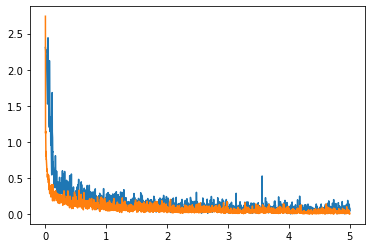

In [32]:
plt.plot(np.linspace(0,epochs, batches),errors)
plt.plot(np.linspace(0,epochs_bn, batches_bn),errors_bn)

In [33]:
model_bnorm.eval()
with torch.no_grad():
    pred = torch.softmax(model_bnorm(train_dataset[:][0]),1)
    ac = torch.sum(torch.argmax(pred,1)==train_dataset[:][1]).to(dtype=torch.float32)/len(train_dataset)
ac  

tensor(0.9962)

In [34]:
model_bnorm.eval()
with torch.no_grad():
    pred = torch.softmax(model_bnorm(test_dataset[:][0]),1)
    ac = torch.sum(torch.argmax(pred,1)==test_dataset[:][1]).to(dtype=torch.float32)/len(test_dataset)
ac    

tensor(0.9828)